In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import cv2
import glob
import shutil
from collections import Counter

from keras.callbacks import Callback
from keras.backend import clear_session

from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import os
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('TensorFlow version', tf.__version__)

Using TensorFlow backend.


TensorFlow version 2.3.1


In [2]:
# Set up path

base_dir = os.path.join(os.getcwd(), 'dataset')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [5]:
folder_list = [x[0] for x in os.walk(base_dir)]
folder_list

['C:\\Users\\user\\Food_Classification\\dataset',
 'C:\\Users\\user\\Food_Classification\\dataset\\cheesecake',
 'C:\\Users\\user\\Food_Classification\\dataset\\chicken_curry',
 'C:\\Users\\user\\Food_Classification\\dataset\\chocolate_ice_cream',
 'C:\\Users\\user\\Food_Classification\\dataset\\french_toast',
 'C:\\Users\\user\\Food_Classification\\dataset\\fried_rice',
 'C:\\Users\\user\\Food_Classification\\dataset\\macarons',
 'C:\\Users\\user\\Food_Classification\\dataset\\nachos',
 'C:\\Users\\user\\Food_Classification\\dataset\\spaghetti_bolognese',
 'C:\\Users\\user\\Food_Classification\\dataset\\sushi',
 'C:\\Users\\user\\Food_Classification\\dataset\\test',
 'C:\\Users\\user\\Food_Classification\\dataset\\waffles']

In [6]:
folder_name = []
for i in folder_list:
    folder_name.append(os.path.basename(os.path.normpath(i)))
folder_name

['dataset',
 'cheesecake',
 'chicken_curry',
 'chocolate_ice_cream',
 'french_toast',
 'fried_rice',
 'macarons',
 'nachos',
 'spaghetti_bolognese',
 'sushi',
 'test',
 'waffles']

In [7]:
not_data_folder = ['dataset','test','train', 'val']
classes = list()

for word in folder_name:   #for each word in line.split()
    if word not in not_data_folder:    #if a word isn't in line.split            
        classes.append(word) 

classes

['cheesecake',
 'chicken_curry',
 'chocolate_ice_cream',
 'french_toast',
 'fried_rice',
 'macarons',
 'nachos',
 'spaghetti_bolognese',
 'sushi',
 'waffles']

In [8]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.copy(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.copy(v, os.path.join(base_dir, 'val', cl))

cheesecake: 50 Images
chicken_curry: 50 Images
chocolate_ice_cream: 50 Images
french_toast: 50 Images
fried_rice: 48 Images
macarons: 50 Images
nachos: 50 Images
spaghetti_bolognese: 49 Images
sushi: 48 Images
waffles: 50 Images


In [9]:
batch_size = 10
IMG_SHAPE = 150

image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size, directory=train_dir, shuffle=True,target_size=(IMG_SHAPE,IMG_SHAPE))

Found 395 images belonging to 10 classes.


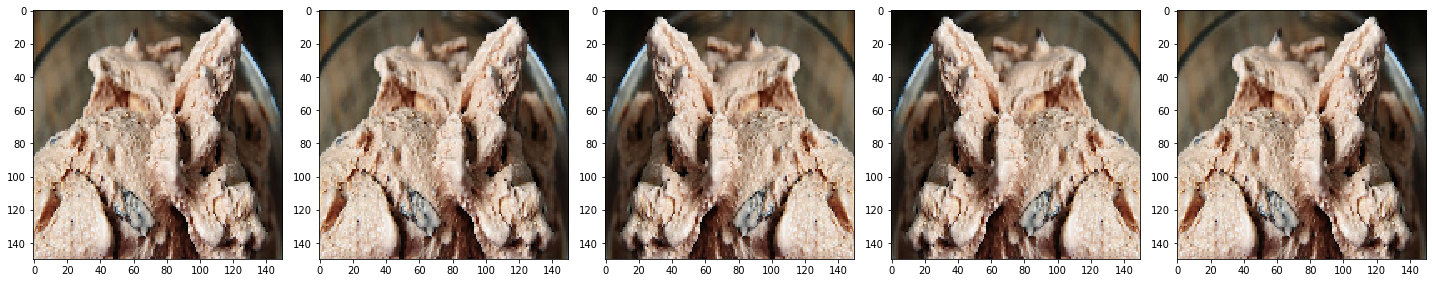

In [10]:
def plotImages(image_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip( image_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 395 images belonging to 10 classes.


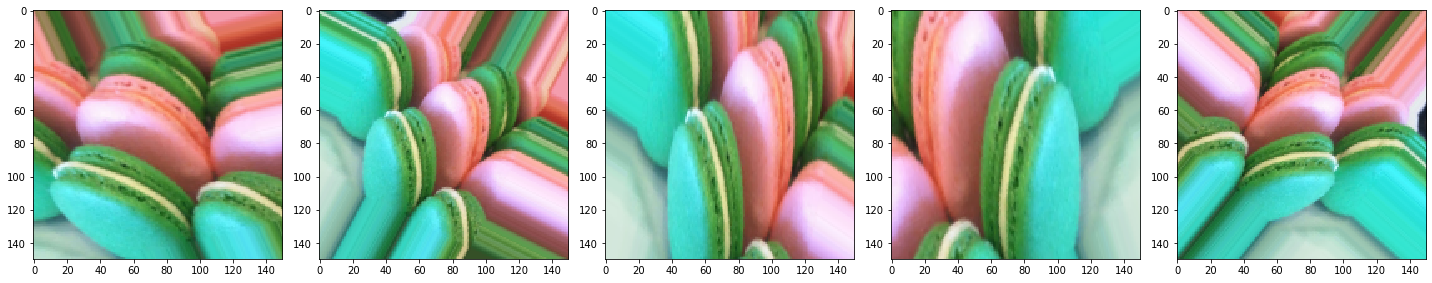

In [11]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [12]:
# validation data

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 100 images belonging to 10 classes.


In [14]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

#Freeze the Pre-Trained Model
feature_extractor.trainable = False

model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(10)
])

model.summary()

NameError: name 'layers' is not defined

In [ ]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# read test data
import PIL
import PIL.Image
import pathlib

test_dir = pathlib.Path(test_dir)
image_count = len(list(test_dir.glob('*')))
print('Total test file: ',image_count)

In [ ]:
def normalize(images):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images

test_image = list(test_dir.glob('*'))

test_array = []
y_pred = []

for test_url in test_image:
    test_img = tf.keras.preprocessing.image.load_img(test_url, target_size=(IMG_SHAPE,IMG_SHAPE))
    img_array = tf.keras.preprocessing.image.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    norm_img_array = normalize(img_array)
    test_array.append(norm_img_array)
    pred = model.predict(norm_img_array)
    print('Prediction :', np.argmax(pred))
    y_pred.append(np.argmax(pred))
    score = tf.nn.softmax(pred[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence score."
        .format(classes[np.argmax(pred)], 100 * np.max(score))
    )
#     print('The actual file name is ', os.path.basename(os.path.normpath(test_url)))

In [ ]:
y_pred

In [ ]:
for i in range(len(test_image)):
    predictions_array, img = y_pred[i], test_image[i]

    img = PIL.Image.open(test_image[i]).resize((IMG_SHAPE,IMG_SHAPE), PIL.Image.ANTIALIAS)
    
    num_rows = 5
    num_cols = 4
    
    plt.figure(figsize=(10, 20))
    plt.subplot(num_rows,num_cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = int(predictions_array)


    plt.xlabel("Image {}, {} {:2.0f}%".format(i, classes[predicted_label],100*np.max(score)))

In [ ]:
from sklearn.metrics import f1_score

y_true = [0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9]

micro_f1_score = f1_score(y_true, y_pred, average='micro')
print('F1 score micro is ', micro_f1_score)
macro_f1_score = f1_score(y_true, y_pred, average='macro')
print('F1 score macro is ', macro_f1_score)
weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
print('F1 score weighted is ', weighted_f1_score)

In [ ]:
print('Avg acc      :', np.mean(acc))
print('Avg val_acc  :', np.mean(val_acc))
print('Avg loss     :', np.mean(loss))
print('Avg val_loss :', np.mean(val_loss))